## 0. Import Libraries and data

In [78]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [79]:
file=open("assessment_log.json",'r') 
lines = file.readlines()

We distinguish 5 main categories of data. We have win market data, place market data, Seamless successful market orders
and their cancelations, failed orders and orders with errors. The first 2 lines of the data also gives more descriptions about the horses and their riders, but we are not going to use this information. We are also not going to explore failed orders and orders with errors due to time constraints. 

In [80]:
i = 0


desc = []

win_market_data = []
place_market_data = []
market_orders = []
failures = []
processed_with_errors = []

sequence_number = None
for line in lines:
    i += 1
    if i <= 2:
        desc.append(json.loads(line))
        continue
    data = json.loads(line)
    
    app_data = data['app_data']
    if 'sequence_number' in app_data:
        sequence_number = app_data['sequence_number']
    elif 'status' in app_data:
        data['sequence_number'] = sequence_number
        
        if app_data['status'] == "SUCCESS":  
            market_orders.append(data)
        if app_data['status'] == 'OPEN':
            if app_data['numberOfWinners'] == 1:    
                win_market_data.append(data)
            if app_data['numberOfWinners'] == 3:
                place_market_data.append(data)
        if app_data['status'] == "FAILURE":
                failures.append(data)
        if app_data['status'] == 'PROCESSED_WITH_ERRORS':
                processed_with_errors.append(data)
        ## no TIMEOUT type, but they are given in Betfair documentaiton
        
        

## 1. Convert data into dataframes

For each horse, we have a separate dict for that horse market data, identifiable by horseId. We then join it into a single dataframe for all horses

In [81]:
## prepare horse market data for loading
horse_market_data = {}
line = json.loads(lines[3])
for horse in line['app_data']['runners']:
    if horse['status'] != 'ACTIVE':
            continue 
    horse_market_data[horse['selectionId']] = {'horse_id': [],'back_price' : [], 'back_size' : [],
                                              'lay_price' : [], 'lay_size' : [],
                                              'last_price_traded' : [], 'spread' : [],
                                              'sequence_number' : [], 'time' : []}

In [82]:
## load horse market data into a convenient format 
for win_market in win_market_data:
    sequence_num = win_market['sequence_number']
    time = win_market['time']
    for horse in win_market['app_data']['runners']:
        if horse['status'] != 'ACTIVE':
            continue
        horse_id = horse['selectionId']

        lob = horse['ex']
        ## best lay price corresponds to availableToBack because if it is availableToBack, we would lay
        ## same goes for best back price 
        best_lay_price = lob['availableToBack'][0]['price'] if lob['availableToBack'] else np.nan
        best_lay_size = lob['availableToBack'][0]['size'] if lob['availableToBack'] else np.nan
        best_back_price = lob['availableToLay'][0]['price'] if lob['availableToLay'] else np.nan
        best_back_size = lob['availableToLay'][0]['size'] if lob['availableToLay'] else np.nan
        last_traded = horse['lastPriceTraded']
        spread = float(best_back_price) - float(best_lay_price)
        horse_market_data[horse_id]['horse_id'].append(horse_id)
        
        horse_market_data[horse_id]['lay_price'].append(best_lay_price)
        horse_market_data[horse_id]['lay_size'].append(best_lay_size)
        horse_market_data[horse_id]['back_price'].append(best_back_price)
        horse_market_data[horse_id]['back_size'].append(best_back_size)
        horse_market_data[horse_id]['last_price_traded'].append(last_traded)
        horse_market_data[horse_id]['spread'].append(spread)
        horse_market_data[horse_id]['sequence_number'].append(sequence_num)
        horse_market_data[horse_id]['time'].append(time)
        
       

We concatinate the horse market data into a single dataframe for easier pandas manipulation.

In [83]:
horse_md_concat = pd.concat([pd.DataFrame(horse_market_data[horse_id]) for horse_id in horse_market_data.keys() ] )
horse_md_concat.head()

,horse_id,back_price,back_size,lay_price,lay_size,last_price_traded,spread,sequence_number,time
0,27157433,2.82,525.87,2.8,820.53,2.82,0.02,NaN,2020-03-24 13:44:14.904
1,27157433,2.82,525.87,2.8,820.53,2.82,0.02,NaN,2020-03-24 13:44:14.982
2,27157433,2.82,525.87,2.8,820.53,2.82,0.02,-1.0,2020-03-24 13:44:15.228
3,27157433,2.82,525.87,2.8,820.53,2.82,0.02,0.0,2020-03-24 13:44:15.498
4,27157433,2.82,525.87,2.8,820.53,2.82,0.02,1.0,2020-03-24 13:44:15.773


Now we clean the order data and put it into a dataframe. We put placed and cancelled orders in one dataframe. 

In [84]:
## create map and then create a dataframe from it 

data_dict = {'date' : [], 'market' : [], 'sequence_number' : [], 'selectionId' : [], 'price' : [], 'size' : [], 'side' : [],
             'sizeCancelled' : [], 'betId' : [], 
             'type' : [], 'sizeMatched' : [], 
             'averagePriceMatched' : []}

place_keys = ['sizeMatched', 'averagePriceMatched']
place_instr_keys = ['side', 'selectionId']
cancel_keys = ['sizeCancelled']
limit_order_keys = ['size', 'price']

for order in market_orders:
    market_type = 'win' if (order['app_data']['marketId'] == '1.170226122') else 'place'
    
    for bet in order['app_data']['instructionReports']:
        data_dict['market'].append(market_type)
        data_dict['sequence_number'].append(order['sequence_number'])
        if 'betId' in bet:     
            data_dict['type'].append('place')
            data_dict['date'].append(bet['placedDate'])
            data_dict['betId'].append(bet['betId'])
            
            instr = bet['instruction']       
            limit_order = instr['limitOrder']
            for key in place_keys:
                data_dict[key].append(bet[key])
            for key in place_instr_keys:
                data_dict[key].append(instr[key])
            ## take limit order from the book 
            for key in limit_order_keys:
                data_dict[key].append(limit_order[key])
            for key in cancel_keys:
                data_dict[key].append(np.nan)
        else:
            data_dict['type'].append('cancel')
            data_dict['betId'].append(bet['instruction']['betId'])
            data_dict['date'].append(bet['cancelledDate'])
            
            for key in cancel_keys:
                data_dict[key].append(bet[key])
            for key in place_keys:
                data_dict[key].append(np.nan)
            for key in place_instr_keys:
                data_dict[key].append(np.nan)
            for key in limit_order_keys:
                data_dict[key].append(np.nan)
     

In [85]:
df = pd.DataFrame.from_dict(data_dict)
df.rename(columns = {'selectionId' : 'horseId'}, inplace = True)

We check how many 'place' and  'win' orders are there.

In [86]:
df[df.market != 'win'].head()

,date,market,sequence_number,horseId,price,size,side,sizeCancelled,betId,type,sizeMatched,averagePriceMatched


In [87]:
df[df.market == 'win'].head()

,date,market,sequence_number,horseId,price,size,side,sizeCancelled,betId,type,sizeMatched,averagePriceMatched
0,2020-03-24T13:57:05.000Z,win,2574,28232003.0,160.0,1.55,BACK,NaN,198774768622,place,0.0,0.0
1,2020-03-24T13:57:05.000Z,win,2574,28232003.0,170.0,1.55,BACK,NaN,198774768623,place,0.0,0.0
2,2020-03-24T13:57:05.000Z,win,2574,28232003.0,180.0,1.55,BACK,NaN,198774768624,place,0.0,0.0
3,2020-03-24T13:57:05.000Z,win,2574,26986439.0,11.0,39.28,BACK,NaN,198774768625,place,0.0,0.0
4,2020-03-24T13:57:05.000Z,win,2574,26986439.0,11.5,39.28,BACK,NaN,198774768626,place,0.0,0.0


So we see that there is no 'place' orders, so Seamless only traded on the 'win' market. We also add information for cancelled bets for convenience by matching them to corresponding placed bets.

In [88]:
## add information for cancelled bets for convenience 
def transfrom(row, df):
    if row.type == 'cancel':
        filtered = df[(df.betId == row.betId) & (df.type == 'place')]
        row['horseId'] = filtered['horseId'].values[0]
        row['price'] = filtered['price'].values[0]
        row['size'] = filtered['size'].values[0]
        row['side'] = filtered['side'].values[0]
        row['sizeMatched'] = filtered['sizeMatched'].values[0]
        row['averagePriceMatched'] = filtered['averagePriceMatched'].values[0]
    return row

In [89]:
df = df.apply(lambda row : transfrom(row, df), axis = 1)

In [90]:
df[df['type'] == 'cancel'].head()

,date,market,sequence_number,horseId,price,size,side,sizeCancelled,betId,type,sizeMatched,averagePriceMatched
44,2020-03-24T13:57:06.000000,win,2577,26986439.0,12.0,39.28,BACK,39.28,198774768627,cancel,0.0,0.0
45,2020-03-24T13:57:06.000000,win,2577,25013915.0,4.7,160.99,LAY,160.99,198774768651,cancel,0.0,0.0
51,2020-03-24T13:57:06.000000,win,2578,25013915.0,4.8,160.99,LAY,160.99,198774768650,cancel,0.0,0.0
55,2020-03-24T13:57:07.000000,win,2579,23225592.0,15.5,4.21,BACK,4.21,198774768883,cancel,0.0,0.0
56,2020-03-24T13:57:07.000000,win,2579,23225592.0,15.5,19.33,BACK,19.33,198774768761,cancel,0.0,0.0


## 2. Analysis 

First we try to check how much Seamless backs and lays on horses depending on their odds.

In [91]:

total_sizes_back = df[(df.side == "BACK") & (df.type == "place") 
                      & (df.averagePriceMatched > 0)].groupby('horseId')['sizeMatched'].sum()
mean_prices_back = df[(df.side == "BACK") & (df.type == "place")
                       & (df.averagePriceMatched > 0)].groupby('horseId')['averagePriceMatched'].mean()
sizes_cancelled_back = df[(df.side == "BACK") & (df.type == "cancel") ].groupby('horseId')['sizeCancelled'].sum()
prices_cancelled_back = df[(df.side == "BACK") & (df.type == "cancel")].groupby('horseId')['price'].mean()

total_sizes_lay = df[(df.side == "LAY") & (df.type == "place")
                     & (df.averagePriceMatched > 0)].groupby('horseId')['sizeMatched'].sum()
mean_prices_lay = df[(df.side == "LAY") 
                      & (df.type == "place")& (df.averagePriceMatched > 0)].groupby('horseId')['averagePriceMatched'].mean()
sizes_cancelled_lay = df[(df.side == "LAY") & (df.type == "cancel")].groupby('horseId')['sizeCancelled'].sum()
prices_cancelled_lay = df[(df.side == "LAY") & (df.type == "cancel")].groupby('horseId')['price'].mean()



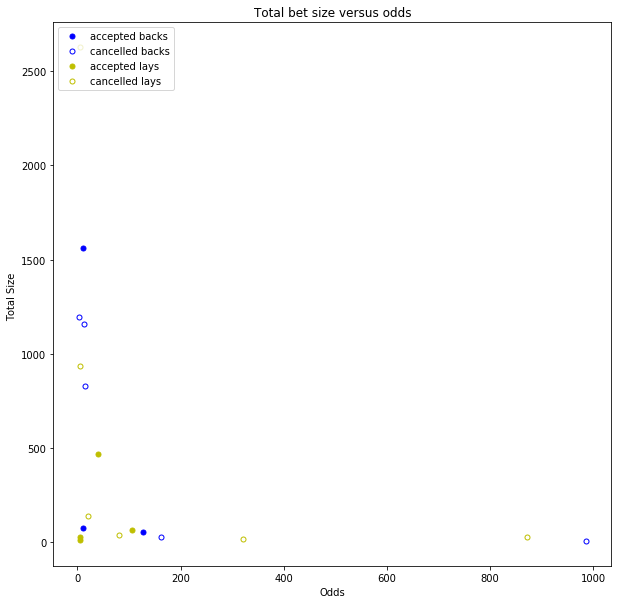

In [92]:
plt.figure(figsize=(10,10))
plt.plot(mean_prices_back, total_sizes_back, 'bo', ms = 5, label = "accepted backs")
plt.plot(prices_cancelled_back,sizes_cancelled_back, 'bo', mfc='none', ms = 5, label = "cancelled backs")

plt.plot(mean_prices_lay, total_sizes_lay, 'yo', ms = 5, label = "accepted lays")
plt.plot(prices_cancelled_lay,sizes_cancelled_lay, 'yo', mfc='none', ms = 5, label = "cancelled lays")

plt.xlabel('Odds')
plt.ylabel('Total Size ')
plt.title('Total bet size versus odds'.format(horse_id))
plt.legend(loc="upper left")

So for this particular case, it seems that Seamless tries to bet large sums for favourites and lay small sums for underdogs, but with some exceptions. In general, it seems that Seamless backed more than layed.

Now we want to check the overround over time to check how efficient the markets are.

In [93]:
lay_overround = horse_md_concat.groupby('sequence_number')['lay_price'].apply(lambda x:np.sum(1/x))
back_overround = horse_md_concat.groupby('sequence_number')['back_price'].apply(lambda x:np.sum(1/x))

In [94]:
def plot_overround(side, data):
    plt.figure(figsize = (15, 5))
    plt.plot(data)
    plt.xlabel('Sequence Number')
    plt.ylabel('Total {} probability'.format(side))
    plt.title('Implied total probabilities for {}s over time (Overround)'.format(side))
    plt.show()

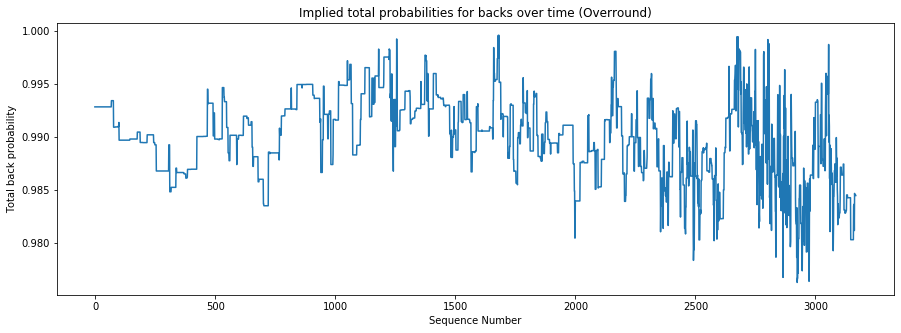

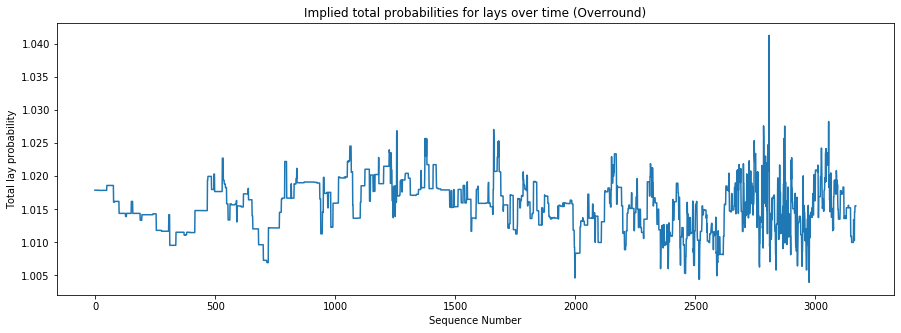

In [95]:
plot_overround('back', back_overround)
plot_overround('lay', lay_overround)

From the above we see that Back markets are quite efficient with overround less than 1. There seems to be more trading after sequence number 2500, when the race is probably about to start. Seamless also starts to trade mostly about this time. Lay markets seem less efficient with total probabilities larger than 1, but not by much. Again there seems to be a lot of movement from around sequence number 2500. 

In [96]:
horse_md_df = pd.DataFrame(horse_market_data[27157433])

In [97]:
horse_md_df.head()

,horse_id,back_price,back_size,lay_price,lay_size,last_price_traded,spread,sequence_number,time
0,27157433,2.82,525.87,2.8,820.53,2.82,0.02,NaN,2020-03-24 13:44:14.904
1,27157433,2.82,525.87,2.8,820.53,2.82,0.02,NaN,2020-03-24 13:44:14.982
2,27157433,2.82,525.87,2.8,820.53,2.82,0.02,-1.0,2020-03-24 13:44:15.228
3,27157433,2.82,525.87,2.8,820.53,2.82,0.02,0.0,2020-03-24 13:44:15.498
4,27157433,2.82,525.87,2.8,820.53,2.82,0.02,1.0,2020-03-24 13:44:15.773


In [98]:
horse_md_df = pd.DataFrame(horse_market_data[horse_id])

In [99]:
def get_graph(horse_id, horse_market_data, df):
    horse_md_df = pd.DataFrame(horse_market_data[horse_id])
    back_orders = df[(df.horseId == horse_id) & (df.type == 'place') & (df.side == 'BACK')]
    back_cancels = df[(df.horseId == horse_id) & (df.type == 'cancel') & (df.side == 'BACK')]
    
    lay_orders = df[(df.horseId == horse_id) & (df.type == 'place') & (df.side == 'LAY') ] #& (df.sizeMatched > 0)
    lay_cancels = df[(df.horseId == horse_id) & (df.type == 'cancel') & (df.side == 'LAY') ] # & (df.sizeMatched > 0)
     
    
    plt.figure(figsize=(15, 5))
   
    ## plot market movements 
    plt.plot(horse_md_df.sequence_number, horse_md_df.back_price, label="best back")
    plt.plot(horse_md_df.sequence_number, horse_md_df.lay_price, label="best lay")
    ## plot orders and their cancelations
    plt.plot(back_orders.sequence_number, back_orders.price, 'bo', ms = 2, label = "back orders")
    plt.plot(back_cancels.sequence_number, back_cancels.price, 'bo', mfc='none', ms = 3, label = "back cancels")
    plt.plot(lay_orders.sequence_number, lay_orders.price, 'yo', ms = 2, label = "lay orders")
    plt.plot(lay_cancels.sequence_number, lay_cancels.price, 'yo',mfc='none', ms = 3, label = "lay cancels")
    
    ## join orders and their cancelations with a line 
    for ind, back_cancel in back_cancels.iterrows():
        back_order = back_orders[back_orders['betId'] == back_cancel['betId']]
        plt.plot([back_order.sequence_number, back_cancel.sequence_number], 
                 [back_order.price, back_cancel.price], 'b--', lw = 2)
    for ind, lay_cancel in lay_cancels.iterrows():
        lay_order = lay_orders[lay_orders['betId'] == lay_cancel['betId']]
        plt.plot([lay_order.sequence_number, lay_cancel.sequence_number], 
                 [lay_order.price, lay_cancel.price], 'y--', lw = 2)

    plt.xlabel('sequence number')
    plt.ylabel('odds')
    plt.title('horse ID {}'.format(horse_id))
    plt.legend(loc="upper left")
    plt.xlim(2000, 3000)

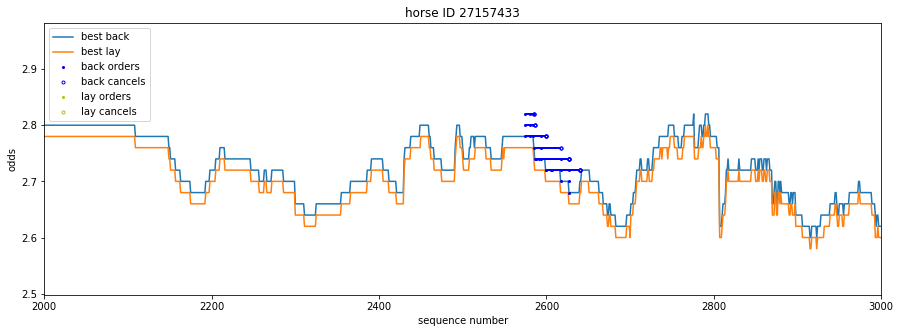

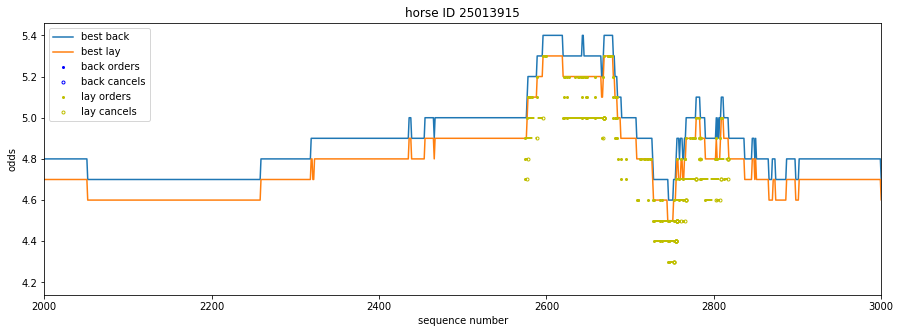

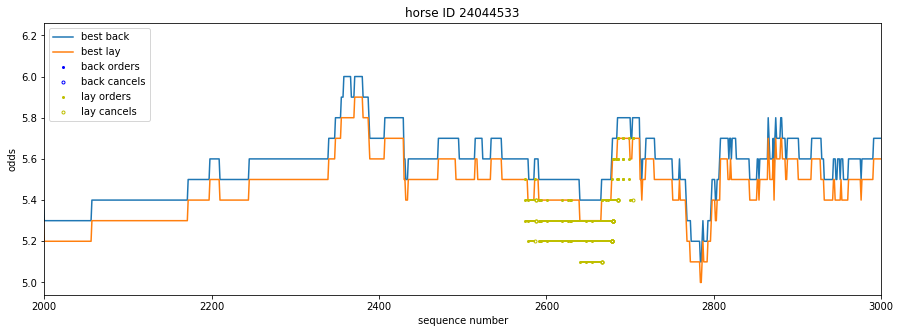

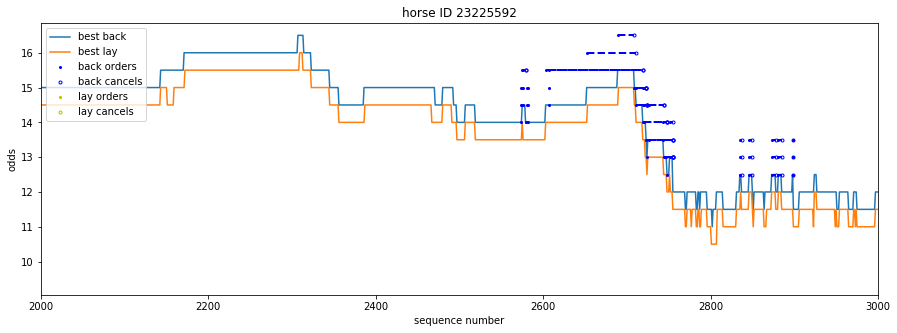

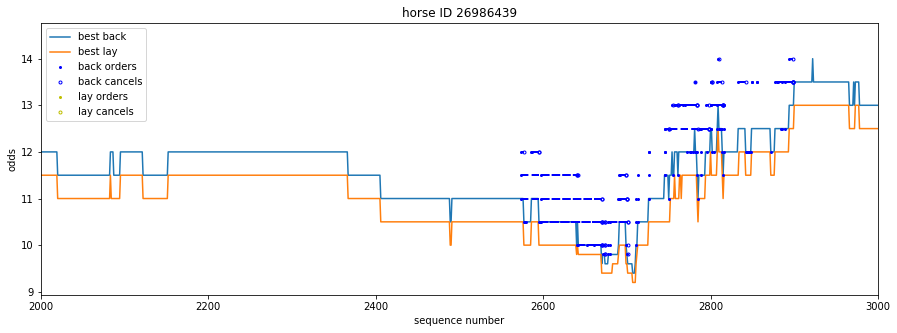

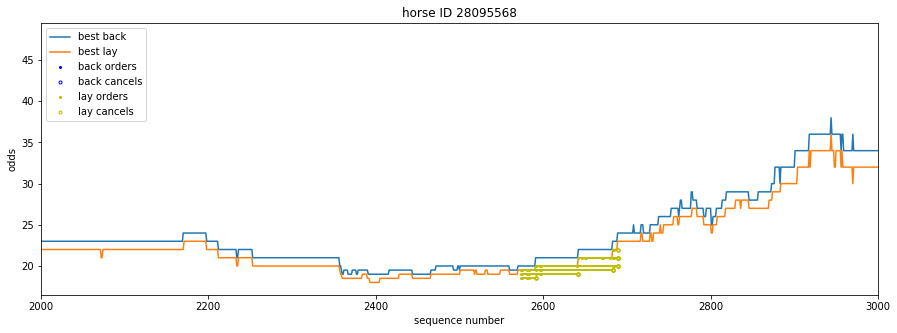

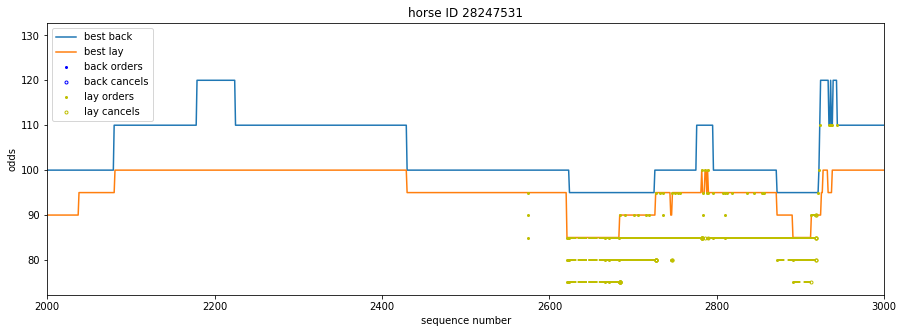

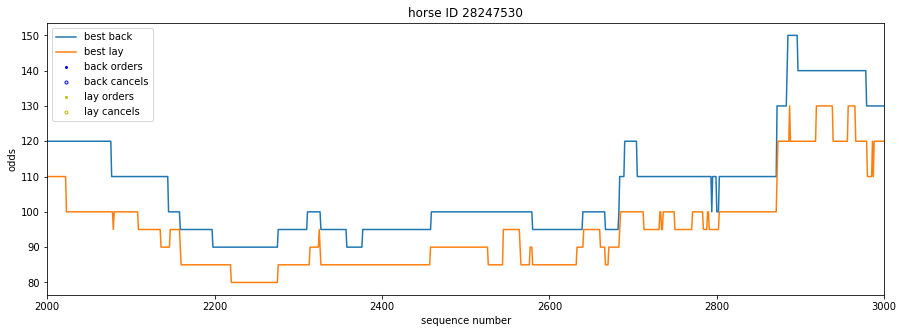

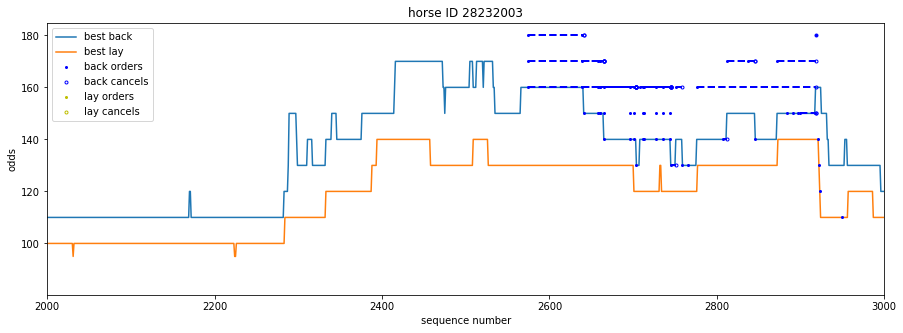

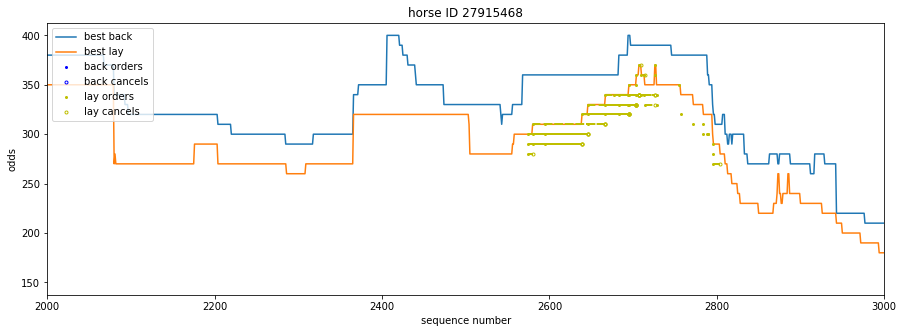

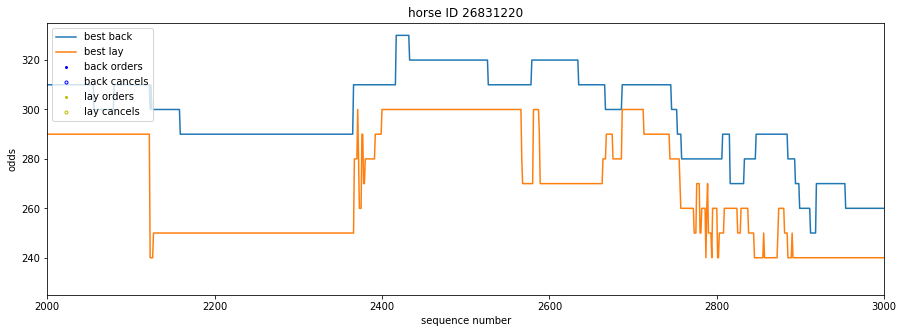

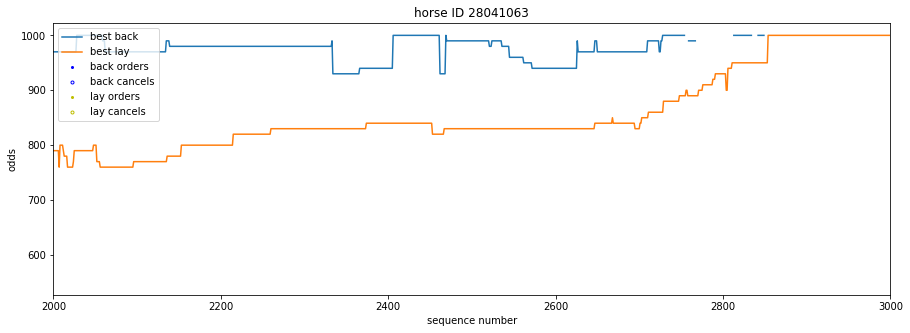

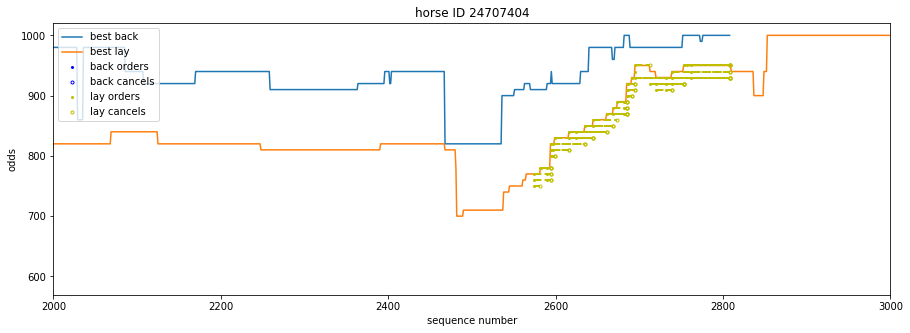

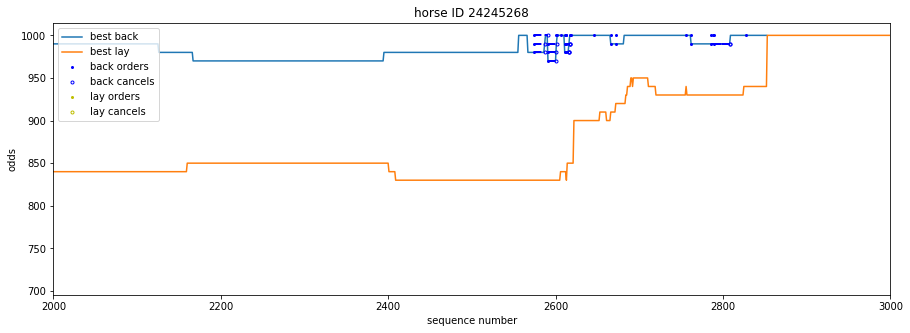

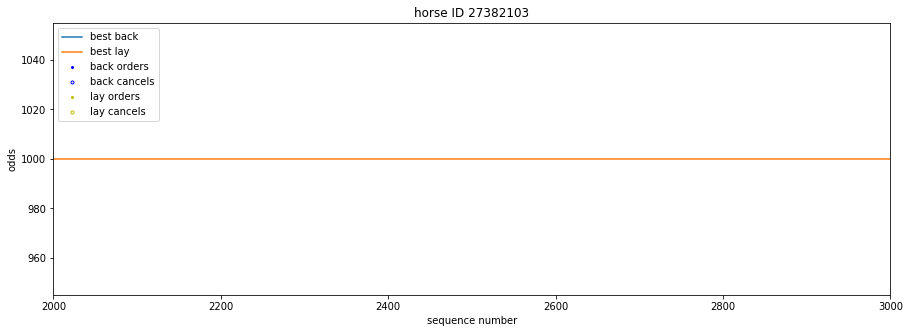

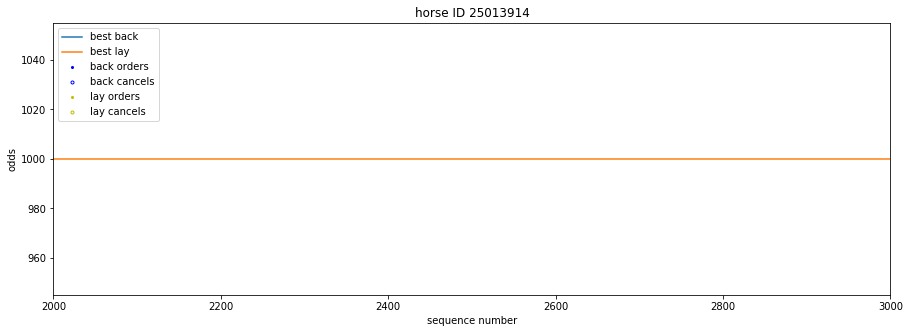

In [100]:
for key in horse_market_data.keys():
    get_graph(key, horse_market_data, df)

## 3. My Thoughts

The algorithm seems passive, mostly placing orders deep in the limit order book. Orders seem to get cancelled quickly if the market does not move in a favourable direction. This wastes bandwidth and would increase market costs in traditional marketts (I am not sure if you have to pay for a limit order on Betfair if it does not get filled). I would guess that the algorithm works by trying to predict upcoming trends and placing orders deep in the order book that would get filled if the trend continued. Also it seems that the algorithm sometimes overpredicts strong market moves and then again orders have to be cancelled. 

We check how many orders are getting cancelled: 

In [101]:
perc = 100 * np.sum(df.type == 'cancel') / (np.shape(df)[0] - np.sum(df.type == 'cancel'))
perc

51.08005082592122

So over 50% or orders got cancelled, which seems quite a lot. 

To get a numeric benchmark for how well the algorithm is doing, I suppose I could calculate VWAP for backs and lays. However, there does not seem to be 'last volume traded' information in the trading logs, so I have no way of calculating VWAP.